In [1]:
# https://github.com/Cyberface/sciml-workshop-dirac/blob/master/course_2.0/07_VAE_basics.ipynb
# https://github.com/Cyberface/sciml-workshop-dirac/blob/master/course_2.0/07_VAE_advanced.ipynb

In [2]:
# this notebook is a step up from the 'Autoencoder.ipynb' notebook
# where I take a look at Variational autoencoders before continuing
# onto conditional variational autoencoders

# imports

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# fix the seed for consistent interpretation of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.4.1


In [2]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

# training set

In [3]:
def gen_model_waveforms(approx, qlist, npts, t_min, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_min=t_min, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_min=t_min, t_max=t_max) for q in qlist]

In [4]:
def make_training_set(wfs, attr):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    return {'x':x, 'y':y}

In [762]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
q_max = 18
dq = 0.1

q_arr = np.arange(q_min, q_max, dq)

# time points
npts=1000
t_min=-500
# t_min=-2000
t_max=75

data_to_model = 'Reh22'
# data_to_model = 'amp'
# data_to_model = 'phase'
# data_to_model = 'freq'

In [763]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

In [764]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts = {}
for approx in approxs:
    model_ts.update({approx:make_training_set(model_wfs[approx], data_to_model)})

In [765]:
common_times = model_wfs[start_approx][0].times

In [766]:
model_ts

{'SEOBNRv4_opt': {'x': array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
          2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
          3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
          4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
          5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
          6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
          7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
          8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
          9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
         10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
         12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
         13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
         14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
    

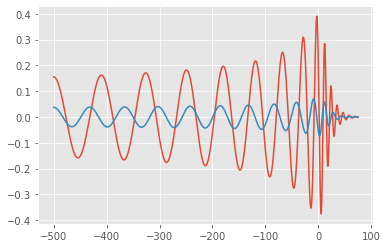

In [767]:
plt.figure()
plt.plot(common_times, model_ts[start_approx]['y'][0])
plt.plot(common_times, model_ts[start_approx]['y'][-1])

In [768]:
train_x = common_times.copy()
train_y = np.asarray([y for y in model_ts[start_approx]['y']])

train_q_labels = np.asarray([x for x in model_ts[start_approx]['x']])

In [769]:
train_y.shape

(170, 1000)

In [770]:
train_q_labels.shape

(170,)

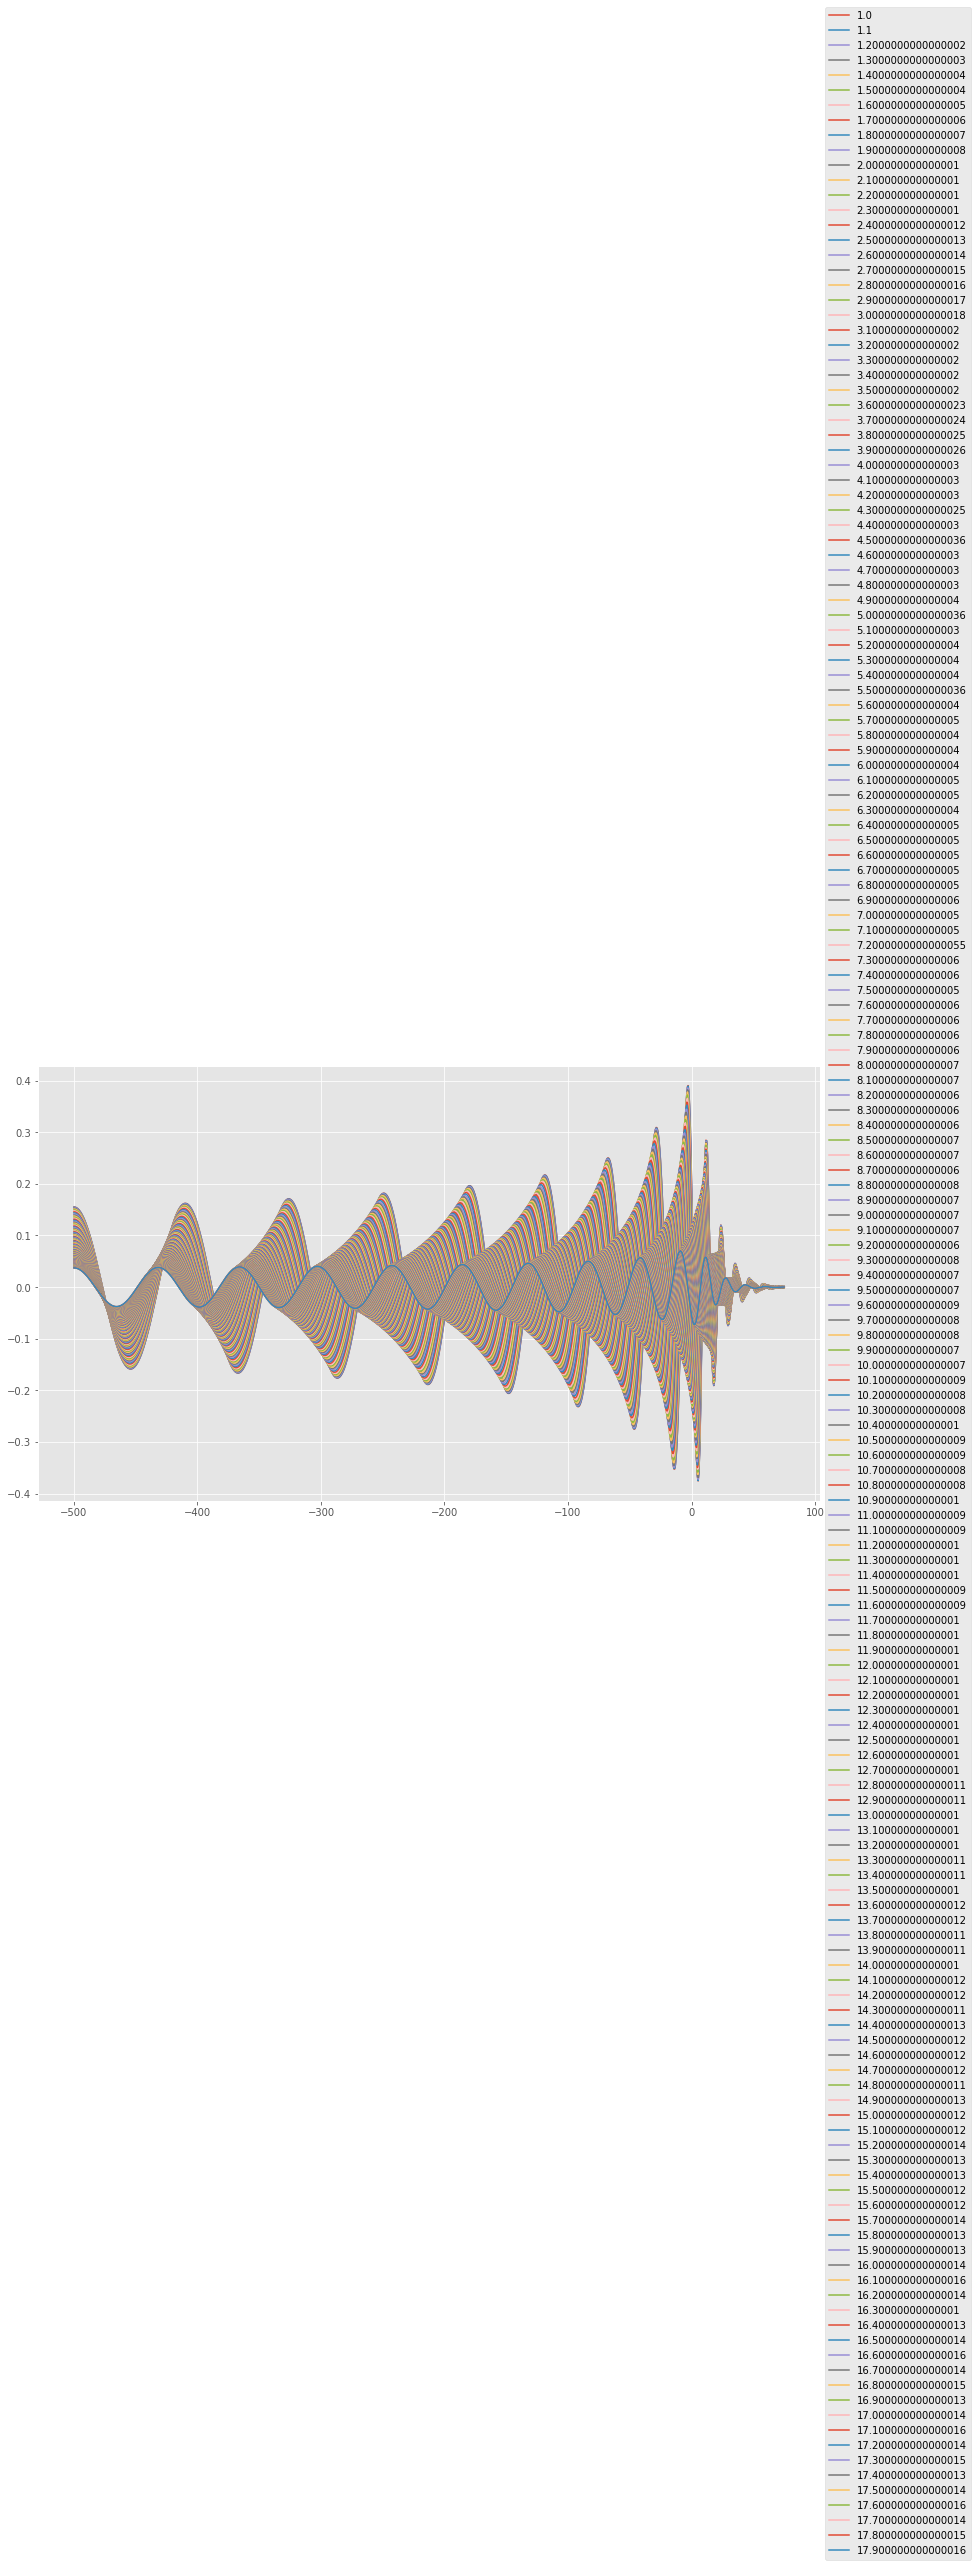

In [771]:
plt.figure(figsize=(14, 8))
for i in range(train_y.shape[0]):
    plt.plot(train_x, train_y[i], label=train_q_labels[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)

# Variational Autoencoder

In [503]:
# we need a way to sample from the probabilistic encoder

In [504]:
# sampling z with (z_mean, z_log_var)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [505]:
# encoder

In [703]:
def build_encoder(input_shape, latent_dim):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape, ))
    x = layers.Dense(128, activation='tanh')(timeseries_input)
    x = layers.Dense(64, activation="tanh")(x)
    x = layers.Dense(16, activation="tanh")(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(timeseries_input, [z_mean, z_log_var, z_output])
    
    return encoder_VAE

In [704]:
# decoder - same as in normal autoencoder

In [705]:
def build_decoder(latent_dim):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation="tanh")(latent_input)
    x = layers.Dense(64, activation="tanh")(x)
    x = layers.Dense(128, activation="tanh")(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_VAE = keras.Model(latent_input, timeseries_output)
    
    return decoder_VAE

In [706]:
# make a VAE class so we can add a KL divergence term to the loss

In [707]:
class VAE(tf.keras.Model):
    # constructor
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        
    # customise train_step() to implement the loss
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error, mse
#             reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(x, x_prime))
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(x, x_prime)
            # reconstruction error, binary cross entropy
#             reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_prime))
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
               "reconstruction_loss": reconstruction_loss,
               "kl_loss": kl_loss}

In [708]:
# # VAE class
# class VAE(keras.Model):
#     # constructor
#     def __init__(self, encoder, decoder, **kwargs):
#         super(VAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder

#     # customise train_step() to implement the loss 
#     def train_step(self, x):
#         if isinstance(x, tuple):
#             x = x[0]
#         with tf.GradientTape() as tape:
#             # encoding
#             z_mean, z_log_var, z = self.encoder(x)
#             # decoding
#             x_prime = self.decoder(z)
#             # reconstruction error by binary crossentropy loss
#             # reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * 28 * 28
#             reconstruction_loss = tf.keras.losses.mean_squared_error(x, x_prime)
#             # KL divergence
#             kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             # loss = reconstruction error + KL divergence
#             loss = reconstruction_loss + kl_loss
#         # apply gradient
#         grads = tape.gradient(loss, self.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#         # return loss for metrics log
#         return {"loss": loss,
#                 "reconstruction_loss": reconstruction_loss,
#                 "kl_loss": kl_loss}

# train model

In [709]:
# latent dimension
latent_dim = 2
# latent_dim = 3
# latent_dim = 10

In [710]:
input_shape = train_y.shape[1] # number of time points

In [711]:
train_y.shape

(100, 1000)

In [712]:
%%time

learning_rate = 0.0001

# beta = 10.
# beta = 1.
# beta = 0.0001
beta = 0.

encoder_VAE = build_encoder(input_shape, latent_dim)
decoder_VAE = build_decoder(latent_dim)

# build VAE model
vae_model = VAE(encoder_VAE, decoder_VAE, beta=beta)


# compile model
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

# fit model
vae_history = vae_model.fit(train_y, train_y, epochs=1000, batch_size=train_y.shape[0]//2)

Epoch 1/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.0244 - reconstruction_loss: 0.0244 - kl_loss: 0.0267
Epoch 2/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.0236 - reconstruction_loss: 0.0236 - kl_loss: 0.0381
Epoch 3/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.0221 - reconstruction_loss: 0.0221 - kl_loss: 0.0958
Epoch 4/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.0218 - reconstruction_loss: 0.0218 - kl_loss: 0.1573
Epoch 5/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0208 - reconstruction_loss: 0.0208 - kl_loss: 0.2015
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0203 - reconstruction_loss: 0.0203 - kl_loss: 0.2315
Epoch 7/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0200 - reconstruction_loss: 0.0200 - kl_loss: 0.2582
Epoch 8/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.0198 - reconstruction_loss: 0.0198 - 

In [713]:
vae_history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])

In [714]:
# plt.figure()
# plt.plot(vae_history.history['lr'])
# plt.yscale('log')

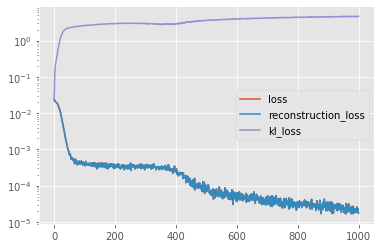

In [715]:
plt.figure()
plt.plot(vae_history.history['loss'], label='loss')
plt.plot(vae_history.history['reconstruction_loss'], label='reconstruction_loss')
plt.plot(vae_history.history['kl_loss'], label='kl_loss')
# plt.plot(vae_history.history['val_loss'])
plt.yscale('log')
plt.legend()

In [716]:
train_encodings_VAE = encoder_VAE.predict(train_y)

In [717]:
train_encodings_VAE[2].shape

(100, 2)

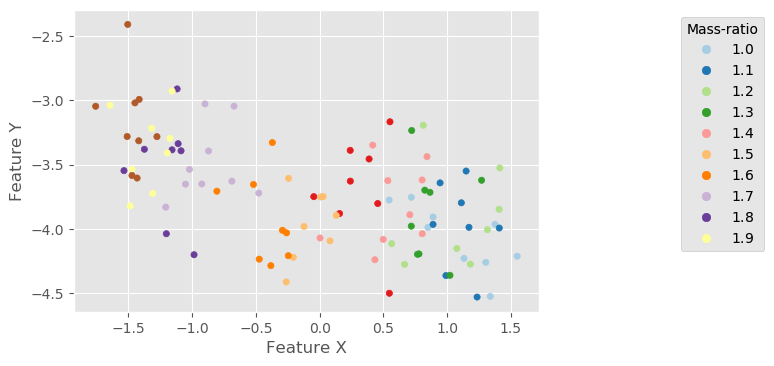

In [718]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=20, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Mass-ratio', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
#     plt.gca().set_aspect(1)
#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
    plt.show()
    
# scatter plot of encodings by AE
scatter_plot_encodings_latent(train_encodings_VAE[2], train_q_labels)

In [719]:
def plot_prediction(index, n_samples=0):
    
    latent_true = train_encodings_VAE[2][index][np.newaxis,:]
    
    if n_samples:
        rvs = np.random.uniform(latent_true-0.1, latent_true+0.1, size=(n_samples, latent_dim))
        yhats = decoder_VAE.predict(rvs)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(train_x, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(train_x, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(train_x, train_y[index], lw=2)
    plt.plot(train_x, decoder_VAE.predict(latent_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_q_labels[index]}')
    
#     plt.xlim(-100, 100)
    
    plt.show()
    plt.close()

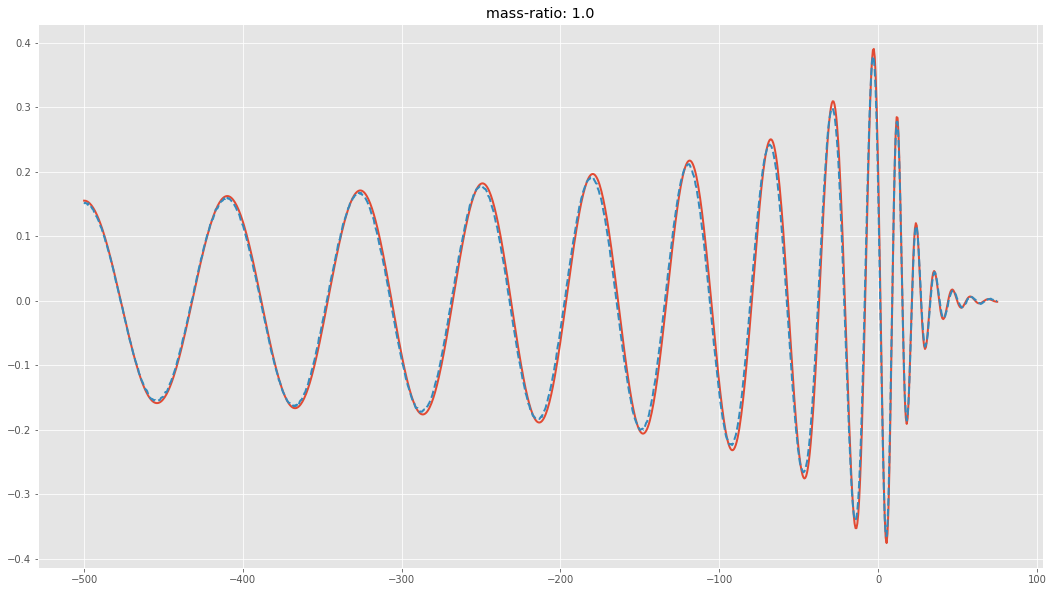

In [720]:
plot_prediction(0, n_samples=0)

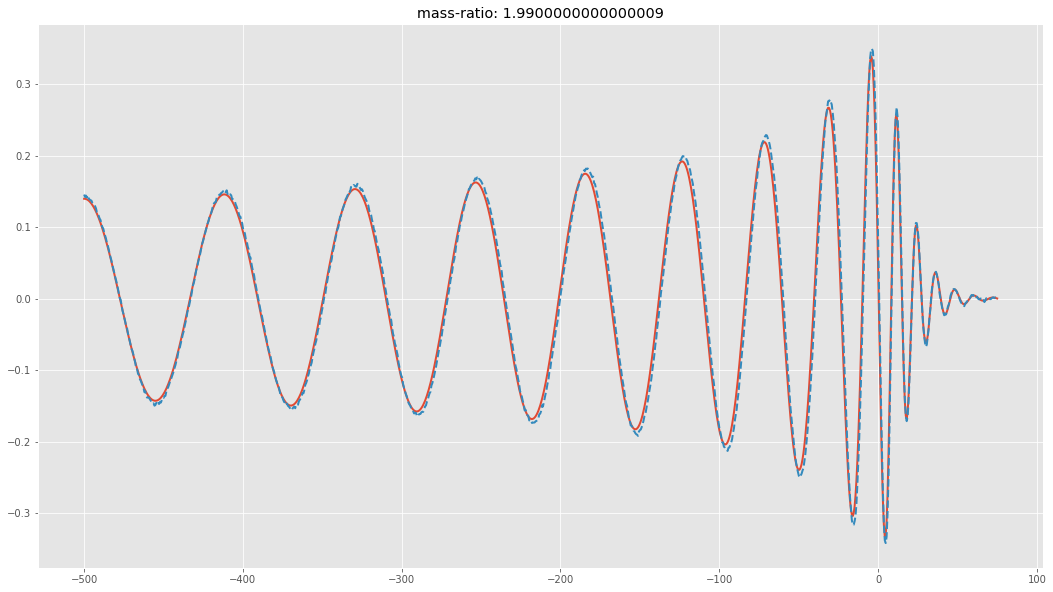

In [721]:
plot_prediction(-1, n_samples=0)

# trying CVAE

In [840]:
def build_conditional_encoder(input_shape, latent_dim, condition_dim):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape + condition_dim, ))
    x = layers.Dense(128, activation='relu')(timeseries_input)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_CVAE = keras.Model(timeseries_input, [z_mean, z_log_var, z_output])
    
    return encoder_CVAE

In [841]:
def build_conditional_decoder(latent_dim):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation="relu")(latent_input)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_VAE = keras.Model(latent_input, timeseries_output)
    
    return decoder_VAE

In [968]:
# CVAE class
class CVAE(keras.Model):
    # constructor
    #################################################################
    ######## NEW: passing condition_dim as an extra argument ########
    #################################################################
    def __init__(self, encoder, decoder, condition_dim, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.condition_dim = condition_dim

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            ####################################################################
            ######## NEW: apply conditions to encodings before decoding ########
            ####################################################################
            z_cond = tf.concat([z, x[:, -self.condition_dim:]], axis=1)
            # decoding
            x_prime = self.decoder(z_cond)
            ###################################################################
            ######## NEW: truncate conditions for reconstruction error ########
            ###################################################################
            # reconstruction error by binary crossentropy loss
#             reconstruction_loss = tf.reduce_mean(
#                 keras.losses.binary_crossentropy(x[:, :-self.condition_dim], x_prime)) * 28 * 28
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(x[:, :-self.condition_dim], x_prime)
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            loss = reconstruction_loss + kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}


In [969]:


# dimension of condition
condition_dim = 1

latent_dim = 2

learning_rate = 0.0001

encoder_CVAE = build_conditional_encoder(input_shape, latent_dim, condition_dim)
decoder_CVAE = build_conditional_decoder(latent_dim + condition_dim)

# build VAE model
cvae_model = CVAE(encoder_CVAE, decoder_CVAE, condition_dim)

# compile model
cvae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

train_y_concatonated = np.concatenate((train_y, train_q_labels[:,np.newaxis]), axis=1)

print(train_y_concatonated.shape)

(170, 1001)


In [ ]:
%%time
# fit model
cvae_history = cvae_model.fit(train_y_concatonated, train_y_concatonated, epochs=5000, batch_size=train_y.shape[0]//2)

Epoch 1/5000
2/2 [==============================] - 0s 3ms/step - loss: 5.6576e-05 - reconstruction_loss: 5.6456e-05 - kl_loss: 1.2049e-07
Epoch 2/5000
2/2 [==============================] - 0s 5ms/step - loss: 5.0447e-05 - reconstruction_loss: 5.0356e-05 - kl_loss: 9.1452e-08
Epoch 3/5000
2/2 [==============================] - 0s 5ms/step - loss: 5.5712e-05 - reconstruction_loss: 5.5612e-05 - kl_loss: 9.9166e-08
Epoch 4/5000
2/2 [==============================] - 0s 4ms/step - loss: 5.4103e-05 - reconstruction_loss: 5.3997e-05 - kl_loss: 1.0571e-07
Epoch 5/5000
2/2 [==============================] - 0s 3ms/step - loss: 5.2330e-05 - reconstruction_loss: 5.2240e-05 - kl_loss: 9.0167e-08
Epoch 6/5000
2/2 [==============================] - 0s 4ms/step - loss: 5.5801e-05 - reconstruction_loss: 5.5722e-05 - kl_loss: 7.9181e-08
Epoch 7/5000
2/2 [==============================] - 0s 4ms/step - loss: 5.5261e-05 - reconstruction_loss: 5.5155e-05 - kl_loss: 1.0618e-07
Epoch 8/5000
2/2 [=========

In [987]:
cvae_history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])

In [988]:
# plt.figure()
# plt.plot(cvae_history.history['lr'])
# plt.yscale('log')

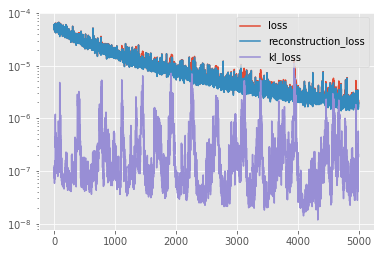

In [989]:
plt.figure()
plt.plot(cvae_history.history['loss'], label='loss')
plt.plot(cvae_history.history['reconstruction_loss'], label='reconstruction_loss')
plt.plot(cvae_history.history['kl_loss'], label='kl_loss')
# plt.plot(cvae_history.history['val_loss'])
plt.yscale('log')
plt.legend()

In [990]:
train_encodings_CVAE = encoder_CVAE.predict(train_y_concatonated)

In [991]:
train_encodings_CVAE[2].shape

(170, 2)

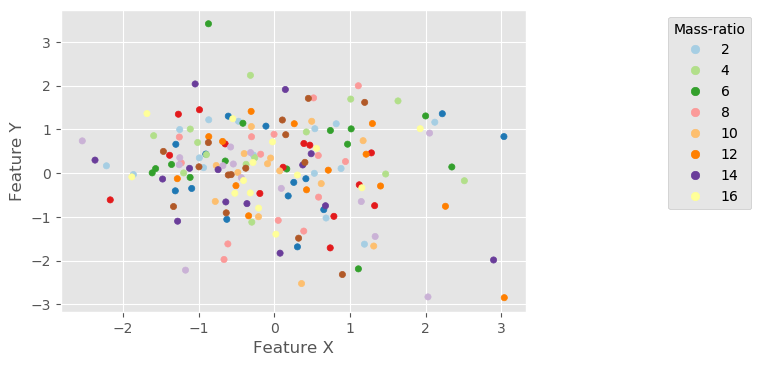

In [992]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=20, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Mass-ratio', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
#     plt.gca().set_aspect(1)
#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
    plt.show()
    
# scatter plot of encodings by AE
scatter_plot_encodings_latent(train_encodings_CVAE[2], train_q_labels)

In [993]:
latent_true = train_encodings_CVAE[2][0][np.newaxis,:]

In [994]:
latent_true

array([[-0.47361827,  1.1854467 ]], dtype=float32)

In [995]:
def my_cvae_prediction(q, nsamples=1, true_val=None):
    q = np.asarray([q])
    q = q[:,np.newaxis]
    
    if nsamples==0:
        rvs = true_val
        inputs = np.concatenate((rvs, q), axis=1)
    else:
        rvs = np.random.normal(0, 1, size=(nsamples, latent_dim))
        inputs = np.concatenate((rvs, np.repeat(q, nsamples, axis=0)), axis=1)
    


    return decoder_CVAE.predict(inputs)

In [996]:
my_cvae_prediction(1.2).shape

(1, 1000)

In [997]:
my_cvae_prediction(2, 100).shape

(100, 1000)

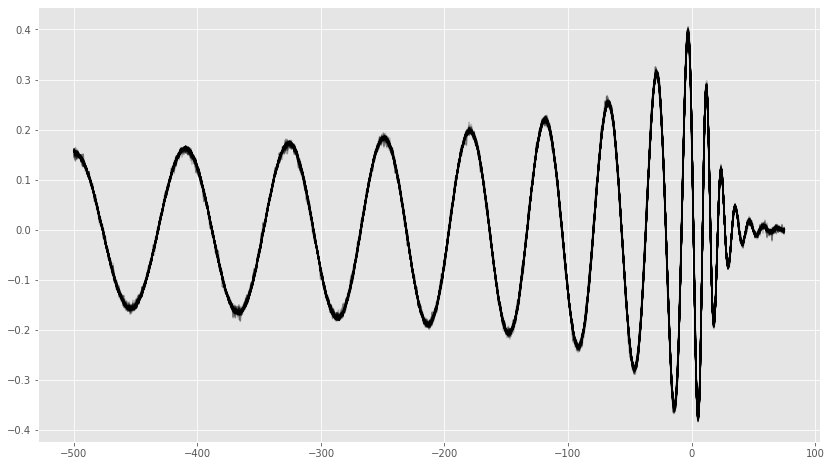

In [998]:
plt.figure(figsize=(14,8))
for yyy in my_cvae_prediction(1, 100):
    plt.plot(train_x, yyy, color='k', alpha=0.2)

In [999]:
def plot_prediction_cvae(index, n_samples=0):
    
    latent_true = train_encodings_CVAE[2][index][np.newaxis,:]
    
    q = train_q_labels[index]
    
    yhat = my_cvae_prediction(q, 0, latent_true)[0]
    
    if n_samples:
        yhats = my_cvae_prediction(q, n_samples)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(train_x, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(train_x, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(train_x, train_y[index], lw=2, label='true')
    plt.plot(train_x, yhat, ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_q_labels[index]}')
    
#     plt.xlim(-100, 100)
    
    plt.legend()
    
    plt.show()
    plt.close()

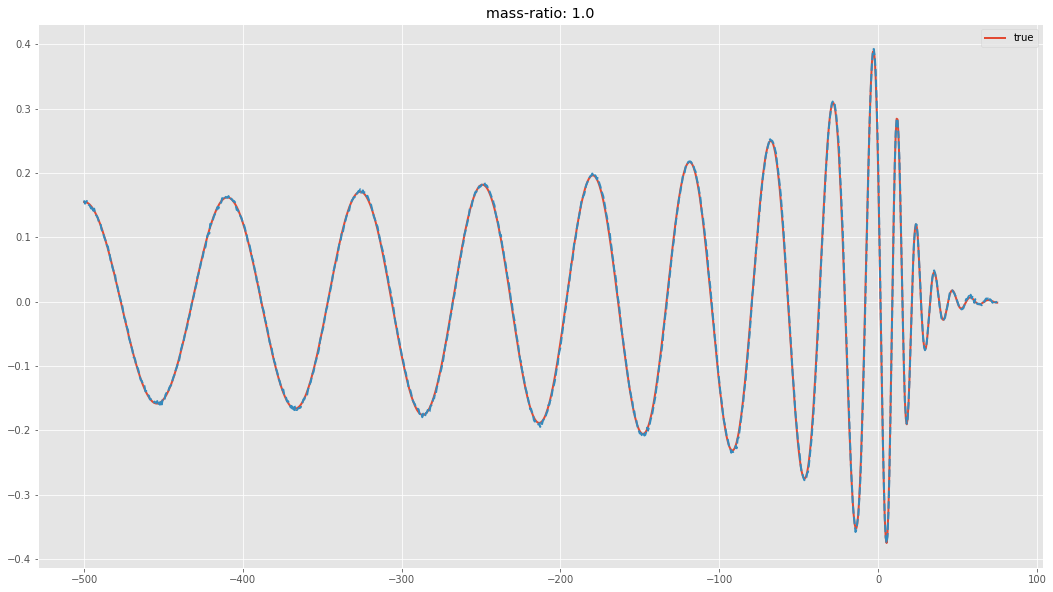

In [1000]:
plot_prediction_cvae(0, n_samples=0)

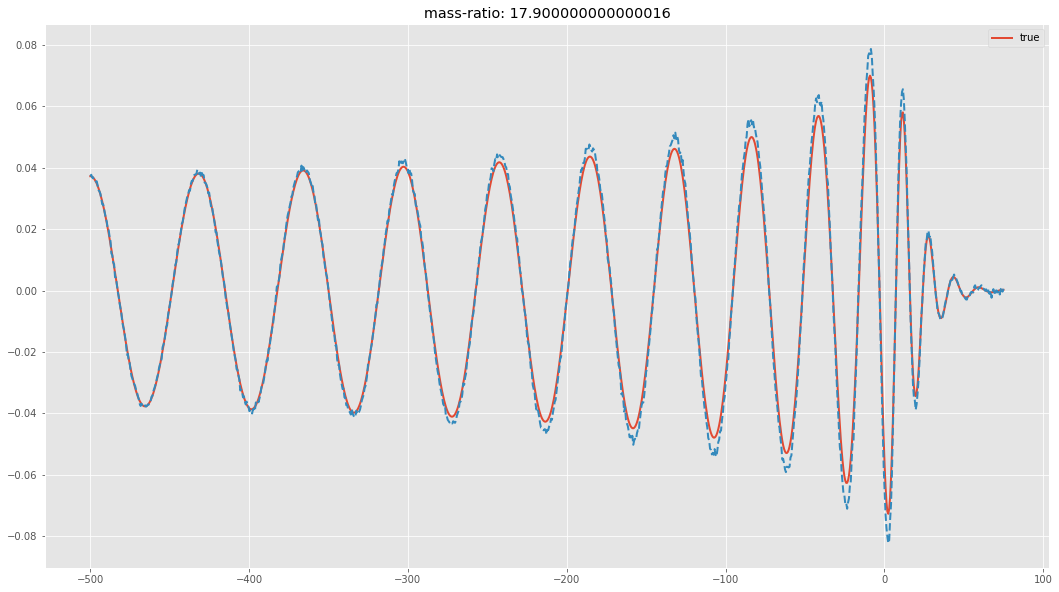

In [1001]:
plot_prediction_cvae(-1, n_samples=0)